In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-01 08:45:05.995622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 08:45:05.995650: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

2022-05-01 08:45:11.423575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 08:45:11.423607: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 08:45:11.423632: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-01 08:45:11.424791: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/41
391/391 [==============================] - 2s 3ms/step - loss: 0.7014 - accuracy: 0.5069 - auc: 0.5103 - val_loss: 0.6898 - val_accuracy: 0.5304 - val_auc: 0.5450
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6946 - accuracy: 0.5210 - auc: 0.5307 - val_loss: 0.6844 - val_accuracy: 0.5630 - val_auc: 0.5894
Epoch 3/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6902 - accuracy: 0.5334 - auc: 0.5478 - val_loss: 0.6789 - val_accuracy: 0.5915 - val_auc: 0.6335
Epoch 4/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6851 - accuracy: 0.5502 - auc: 0.5699 - val_loss: 0.6720 - val_accuracy: 0.6209 - val_auc: 0.6777
Epoch 5/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6786 - accuracy: 0.5662 - auc: 0.5958 - val_loss: 0.6627 - val_accuracy: 0.6544 - val_auc: 0.7219
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6700 - accuracy: 0.5872 - auc: 0.6262 - val_loss: 0.64

391/391 [==============================] - 2s 4ms/step - loss: 0.5690 - accuracy: 0.7072 - auc: 0.7843 - val_loss: 0.4872 - val_accuracy: 0.8281 - val_auc: 0.9018
Epoch 6/41
391/391 [==============================] - 2s 4ms/step - loss: 0.5398 - accuracy: 0.7295 - auc: 0.8101 - val_loss: 0.4484 - val_accuracy: 0.8457 - val_auc: 0.9153
Epoch 7/41
391/391 [==============================] - 2s 4ms/step - loss: 0.5134 - accuracy: 0.7504 - auc: 0.8323 - val_loss: 0.4184 - val_accuracy: 0.8584 - val_auc: 0.9245
Epoch 8/41
391/391 [==============================] - 2s 4ms/step - loss: 0.4949 - accuracy: 0.7634 - auc: 0.8459 - val_loss: 0.3960 - val_accuracy: 0.8689 - val_auc: 0.9309
Epoch 9/41
391/391 [==============================] - 2s 4ms/step - loss: 0.4814 - accuracy: 0.7753 - auc: 0.8561 - val_loss: 0.3794 - val_accuracy: 0.8774 - val_auc: 0.9354
Epoch 10/41
391/391 [==============================] - 2s 4ms/step - loss: 0.4686 - accuracy: 0.7846 - auc: 0.8646 - val_loss: 0.3667 - val_a

391/391 [==============================] - 1s 3ms/step - loss: 0.4534 - accuracy: 0.7969 - auc: 0.8751 - val_loss: 0.3505 - val_accuracy: 0.8917 - val_auc: 0.9430
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4436 - accuracy: 0.8041 - auc: 0.8819 - val_loss: 0.3422 - val_accuracy: 0.8947 - val_auc: 0.9448
Epoch 11/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4372 - accuracy: 0.8097 - auc: 0.8863 - val_loss: 0.3363 - val_accuracy: 0.8982 - val_auc: 0.9459
Epoch 12/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4268 - accuracy: 0.8169 - auc: 0.8920 - val_loss: 0.3304 - val_accuracy: 0.9007 - val_auc: 0.9468
Epoch 13/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4214 - accuracy: 0.8220 - auc: 0.8953 - val_loss: 0.3258 - val_accuracy: 0.9025 - val_auc: 0.9476
Epoch 14/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4152 - accuracy: 0.8277 - auc: 0.8990 - val_loss: 0.3216 - v

391/391 [==============================] - 1s 3ms/step - loss: 0.6666 - accuracy: 0.5959 - auc: 0.6352 - val_loss: 0.6473 - val_accuracy: 0.6830 - val_auc: 0.7734
Epoch 14/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6611 - accuracy: 0.6041 - auc: 0.6485 - val_loss: 0.6388 - val_accuracy: 0.6987 - val_auc: 0.7896
Epoch 15/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6549 - accuracy: 0.6126 - auc: 0.6623 - val_loss: 0.6286 - val_accuracy: 0.7172 - val_auc: 0.8043
Epoch 16/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6468 - accuracy: 0.6261 - auc: 0.6787 - val_loss: 0.6168 - val_accuracy: 0.7345 - val_auc: 0.8195
Epoch 17/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6385 - accuracy: 0.6394 - auc: 0.6939 - val_loss: 0.6033 - val_accuracy: 0.7489 - val_auc: 0.8337
Epoch 18/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6280 - accuracy: 0.6503 - auc: 0.7102 - val_loss: 0.5879 - v

Epoch 60/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3609 - accuracy: 0.8660 - auc: 0.9254 - val_loss: 0.2862 - val_accuracy: 0.9236 - val_auc: 0.9537
Epoch 61/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3607 - accuracy: 0.8675 - auc: 0.9258 - val_loss: 0.2850 - val_accuracy: 0.9237 - val_auc: 0.9539
Epoch 62/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3584 - accuracy: 0.8682 - auc: 0.9266 - val_loss: 0.2836 - val_accuracy: 0.9245 - val_auc: 0.9541
Epoch 63/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3549 - accuracy: 0.8710 - auc: 0.9281 - val_loss: 0.2823 - val_accuracy: 0.9245 - val_auc: 0.9543
Epoch 64/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3529 - accuracy: 0.8712 - auc: 0.9287 - val_loss: 0.2810 - val_accuracy: 0.9251 - val_auc: 0.9545
Epoch 65/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3528 - accuracy: 0.8704 - auc: 0.9287 - val_loss

391/391 [==============================] - 1s 3ms/step - loss: 0.4429 - accuracy: 0.8090 - auc: 0.8832 - val_loss: 0.3374 - val_accuracy: 0.9046 - val_auc: 0.9475
Epoch 22/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4372 - accuracy: 0.8137 - auc: 0.8869 - val_loss: 0.3331 - val_accuracy: 0.9054 - val_auc: 0.9478
Epoch 23/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4302 - accuracy: 0.8189 - auc: 0.8909 - val_loss: 0.3289 - val_accuracy: 0.9071 - val_auc: 0.9482
Epoch 24/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4296 - accuracy: 0.8198 - auc: 0.8918 - val_loss: 0.3260 - val_accuracy: 0.9075 - val_auc: 0.9485
Epoch 25/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4233 - accuracy: 0.8271 - auc: 0.8960 - val_loss: 0.3232 - val_accuracy: 0.9086 - val_auc: 0.9488
Epoch 26/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4180 - accuracy: 0.8313 - auc: 0.8990 - val_loss: 0.3203 - v

Epoch 68/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3206 - accuracy: 0.8809 - auc: 0.9393 - val_loss: 0.2595 - val_accuracy: 0.9250 - val_auc: 0.9606
Epoch 69/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3206 - accuracy: 0.8806 - auc: 0.9395 - val_loss: 0.2589 - val_accuracy: 0.9247 - val_auc: 0.9608
Epoch 70/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3166 - accuracy: 0.8818 - auc: 0.9408 - val_loss: 0.2582 - val_accuracy: 0.9246 - val_auc: 0.9610
Epoch 71/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3135 - accuracy: 0.8821 - auc: 0.9416 - val_loss: 0.2571 - val_accuracy: 0.9247 - val_auc: 0.9612
Epoch 72/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3150 - accuracy: 0.8824 - auc: 0.9412 - val_loss: 0.2565 - val_accuracy: 0.9252 - val_auc: 0.9613
Epoch 73/84
391/391 [==============================] - 1s 3ms/step - loss: 0.3140 - accuracy: 0.8832 - auc: 0.9417 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.3863 - accuracy: 0.8530 - auc: 0.9148 - val_loss: 0.3002 - val_accuracy: 0.9160 - val_auc: 0.9518
Epoch 30/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3801 - accuracy: 0.8556 - auc: 0.9174 - val_loss: 0.2981 - val_accuracy: 0.9165 - val_auc: 0.9520
Epoch 31/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3774 - accuracy: 0.8567 - auc: 0.9188 - val_loss: 0.2960 - val_accuracy: 0.9175 - val_auc: 0.9523
Epoch 32/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3725 - accuracy: 0.8591 - auc: 0.9207 - val_loss: 0.2939 - val_accuracy: 0.9177 - val_auc: 0.9526
Epoch 33/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3732 - accuracy: 0.8610 - auc: 0.9205 - val_loss: 0.2923 - val_accuracy: 0.9183 - val_auc: 0.9529
Epoch 34/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3702 - accuracy: 0.8617 - auc: 0.9216 - val_loss: 0.2905 - v

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2976 - accuracy: 0.8900 - auc: 0.9472 - val_loss: 0.2447 - val_accuracy: 0.9280 - val_auc: 0.9638
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2947 - accuracy: 0.8907 - auc: 0.9477 - val_loss: 0.2442 - val_accuracy: 0.9276 - val_auc: 0.9639
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2946 - accuracy: 0.8906 - auc: 0.9480 - val_loss: 0.2439 - val_accuracy: 0.9282 - val_auc: 0.9640
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2943 - accuracy: 0.8911 - auc: 0.9481 - val_loss: 0.2431 - val_accuracy: 0.9281 - val_auc: 0.9641
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2923 - accuracy: 0.8906 - auc: 0.9486 - val_loss: 0.2425 - val_accuracy: 0.9280 - val_auc: 0.9642
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2923 - accuracy: 0.8924 - auc: 0.9486 - val_loss

Epoch 2/3
12512/12512 [==============================] - 23s 2ms/step - loss: 0.3102 - accuracy: 0.8836 - auc: 0.9426 - val_loss: 0.2616 - val_accuracy: 0.9067 - val_auc: 0.9582
Epoch 3/3
12512/12512 [==============================] - 22s 2ms/step - loss: 0.3076 - accuracy: 0.8855 - auc: 0.9441 - val_loss: 0.2510 - val_accuracy: 0.9103 - val_auc: 0.9619
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.25097405910491943, 'epoch': 3}, 'best_auc': {'auc': 0.9618867635726929, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9103000164031982, 'epoch': 3}}
Epoch 1/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.5871 - accuracy: 0.6726 - auc: 0.7518 - val_loss: 0.3647 - val_accuracy: 0.8846 - val_auc: 0.9396
Epoch 2/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.4321 - accuracy: 0.8158 - auc: 0.8905 - val_loss: 0.3124 - val_accuracy: 0.9071 - val_auc: 0.9485
Epoch 3/4
12512/12512 [======================

IOStream.flush timed out


12512/12512 [==============================] - 318s 25ms/step - loss: 0.4103 - accuracy: 0.8346 - auc: 0.9041 - val_loss: 0.3039 - val_accuracy: 0.9144 - val_auc: 0.9505
Epoch 3/4
12512/12512 [==============================] - 51s 4ms/step - loss: 0.3727 - accuracy: 0.8610 - auc: 0.9215 - val_loss: 0.2851 - val_accuracy: 0.9181 - val_auc: 0.9534
Epoch 4/4
12512/12512 [==============================] - 35s 3ms/step - loss: 0.3412 - accuracy: 0.8758 - auc: 0.9335 - val_loss: 0.2703 - val_accuracy: 0.9186 - val_auc: 0.9570
{'learning_rate': 0.12, 'batch': 8, 'epoch': 2, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.27030235528945923, 'epoch': 4}, 'best_auc': {'auc': 0.9570401906967163, 'epoch': 4}, 'best_accuracy': {'accuracy': 0.9186499714851379, 'epoch': 4}}
Epoch 1/3
12512/12512 [==============================] - 41s 3ms/step - loss: 0.3084 - accuracy: 0.8813 - auc: 0.9426 - val_loss: 0.2162 - val_accuracy: 0.9268 - val_auc: 0.9681
Epoch 2/3
12512/12512 [============================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 23s 2ms/step - loss: 0.3035 - accuracy: 0.8818 - auc: 0.9437 - val_loss: 0.2243 - val_accuracy: 0.9215 - val_auc: 0.9672
Epoch 2/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.2470 - accuracy: 0.9133 - auc: 0.9597 - val_loss: 0.2171 - val_accuracy: 0.9257 - val_auc: 0.9678
Epoch 3/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.2406 - accuracy: 0.9168 - auc: 0.9614 - val_loss: 0.2132 - val_accuracy: 0.9278 - val_auc: 0.9695


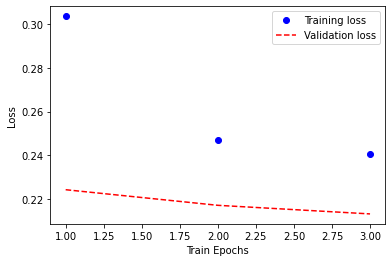

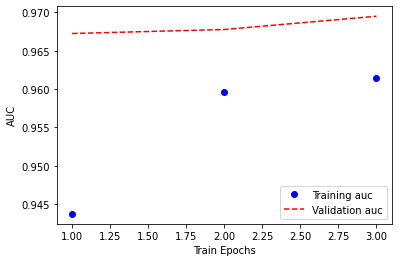

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

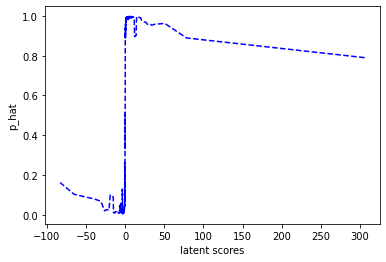

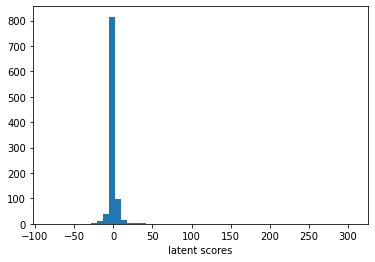

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

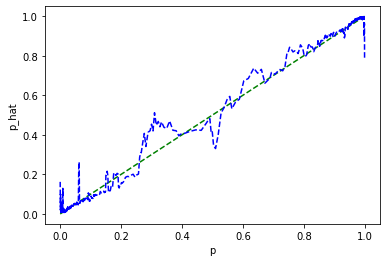

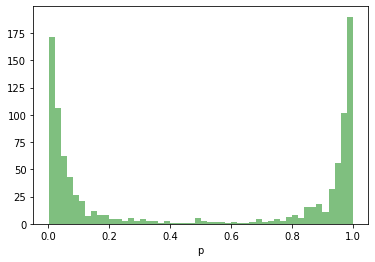

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

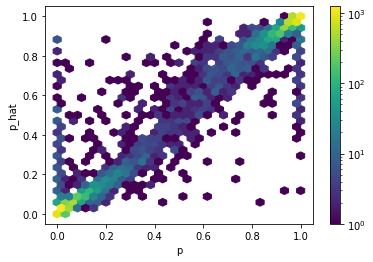

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

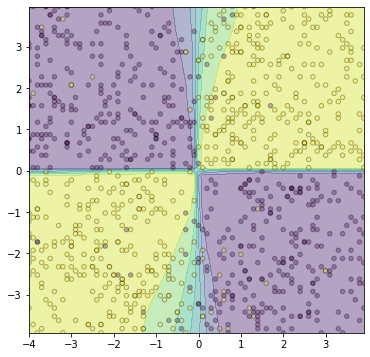

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.0084,
 'batch': 8,
 'epoch': 1,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.2118806689977646, 'epoch': 3},
 'best_auc': {'auc': 0.9699461460113525, 'epoch': 3},
 'best_accuracy': {'accuracy': 0.9291499853134155, 'epoch': 3},
 'model': <keras.engine.sequential.Sequential at 0x7f5a71102d60>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.30287569761276245, 'epoch': 41},
  'best_auc': {'auc': 0.951335608959198, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9148499965667725, 'epoch': 41}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2741614878177643, 'epoch': 41},
  'best_auc': {'auc': 0.956847071647644, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.922249972820282, 'epoch': 41}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2596724331378937, 'epoch': 41},
  'best_auc': {'auc': 0.9603559374809265, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9241499900817871, 'epoch': 41}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.25808897614479065, 'epoch': 84},
  'best_auc': {'auc': 0.9590056538581848, 'epoch': 84},
  'best_accuracy':

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25